In [23]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.models as models
import autoencodeSVJ.trainer as trainer
import glob
import os
import numpy as np

### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [24]:
# get h5 datasets
data,jet_tables = utils.get_training_data_jets("../../data/dijet_tight/*data.h5")
data.head()

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/0.0_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/7_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/8_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/6_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/5_data.h5'
data_loader :: Grabbing dataset with keys [u

,jetEta,jetPhi,jetPt,jetM,jetChargedFraction,jetPTD,jetAxis2
0,0.391208,3.126895,880.629578,46.972202,0.941176,0.238104,0.041430
1,0.226281,1.619783,839.069214,27.909035,0.631579,0.254852,0.016366
2,1.215448,0.042642,1736.550293,164.827713,0.608696,0.418112,0.006629
3,-0.121109,-1.891376,453.773132,62.488964,0.771429,0.162267,0.079624
4,1.025759,3.117460,882.341492,160.383484,0.600000,0.215028,0.021459


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train', 'test']


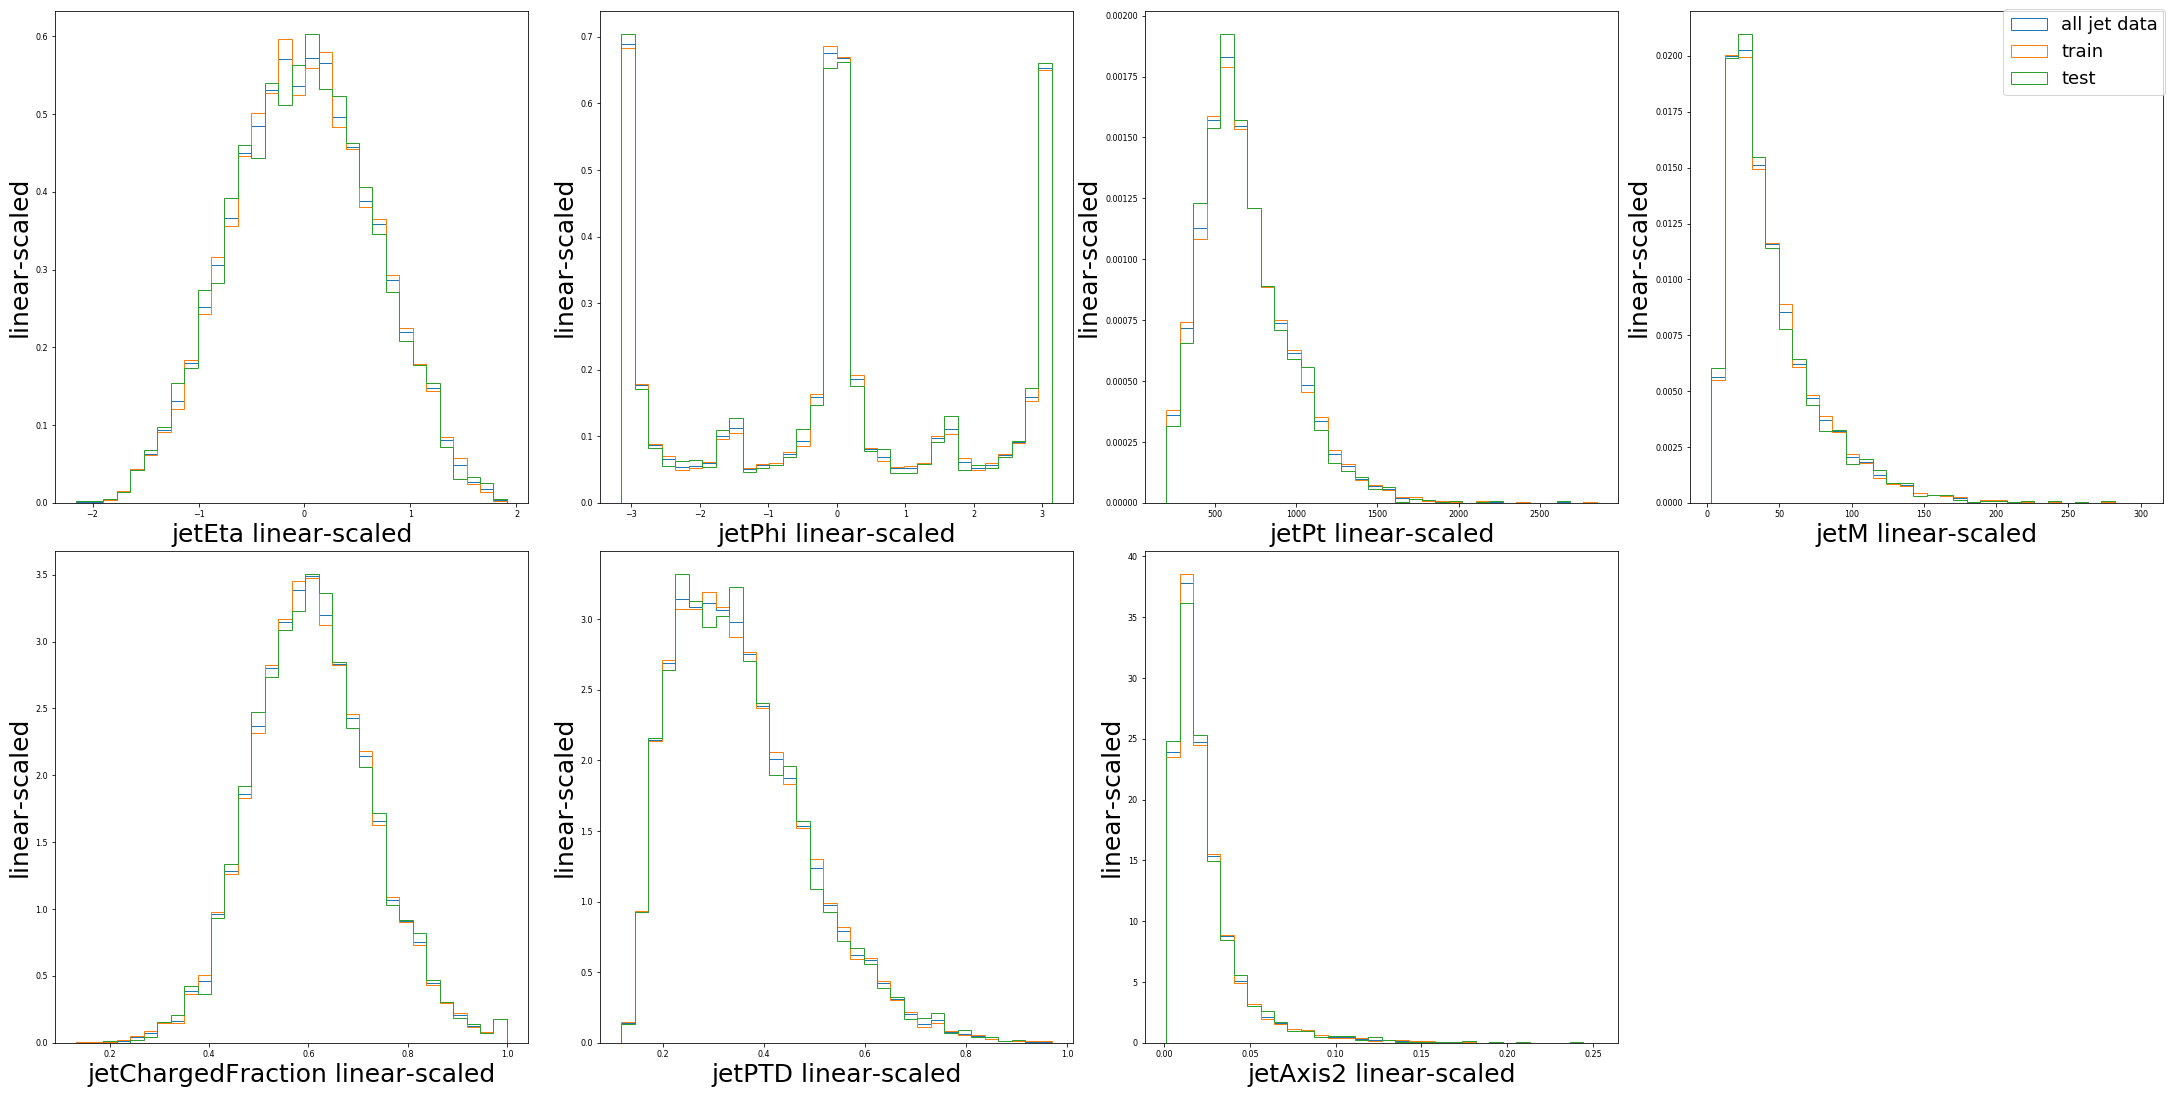

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'jet 0', 'jet 1']


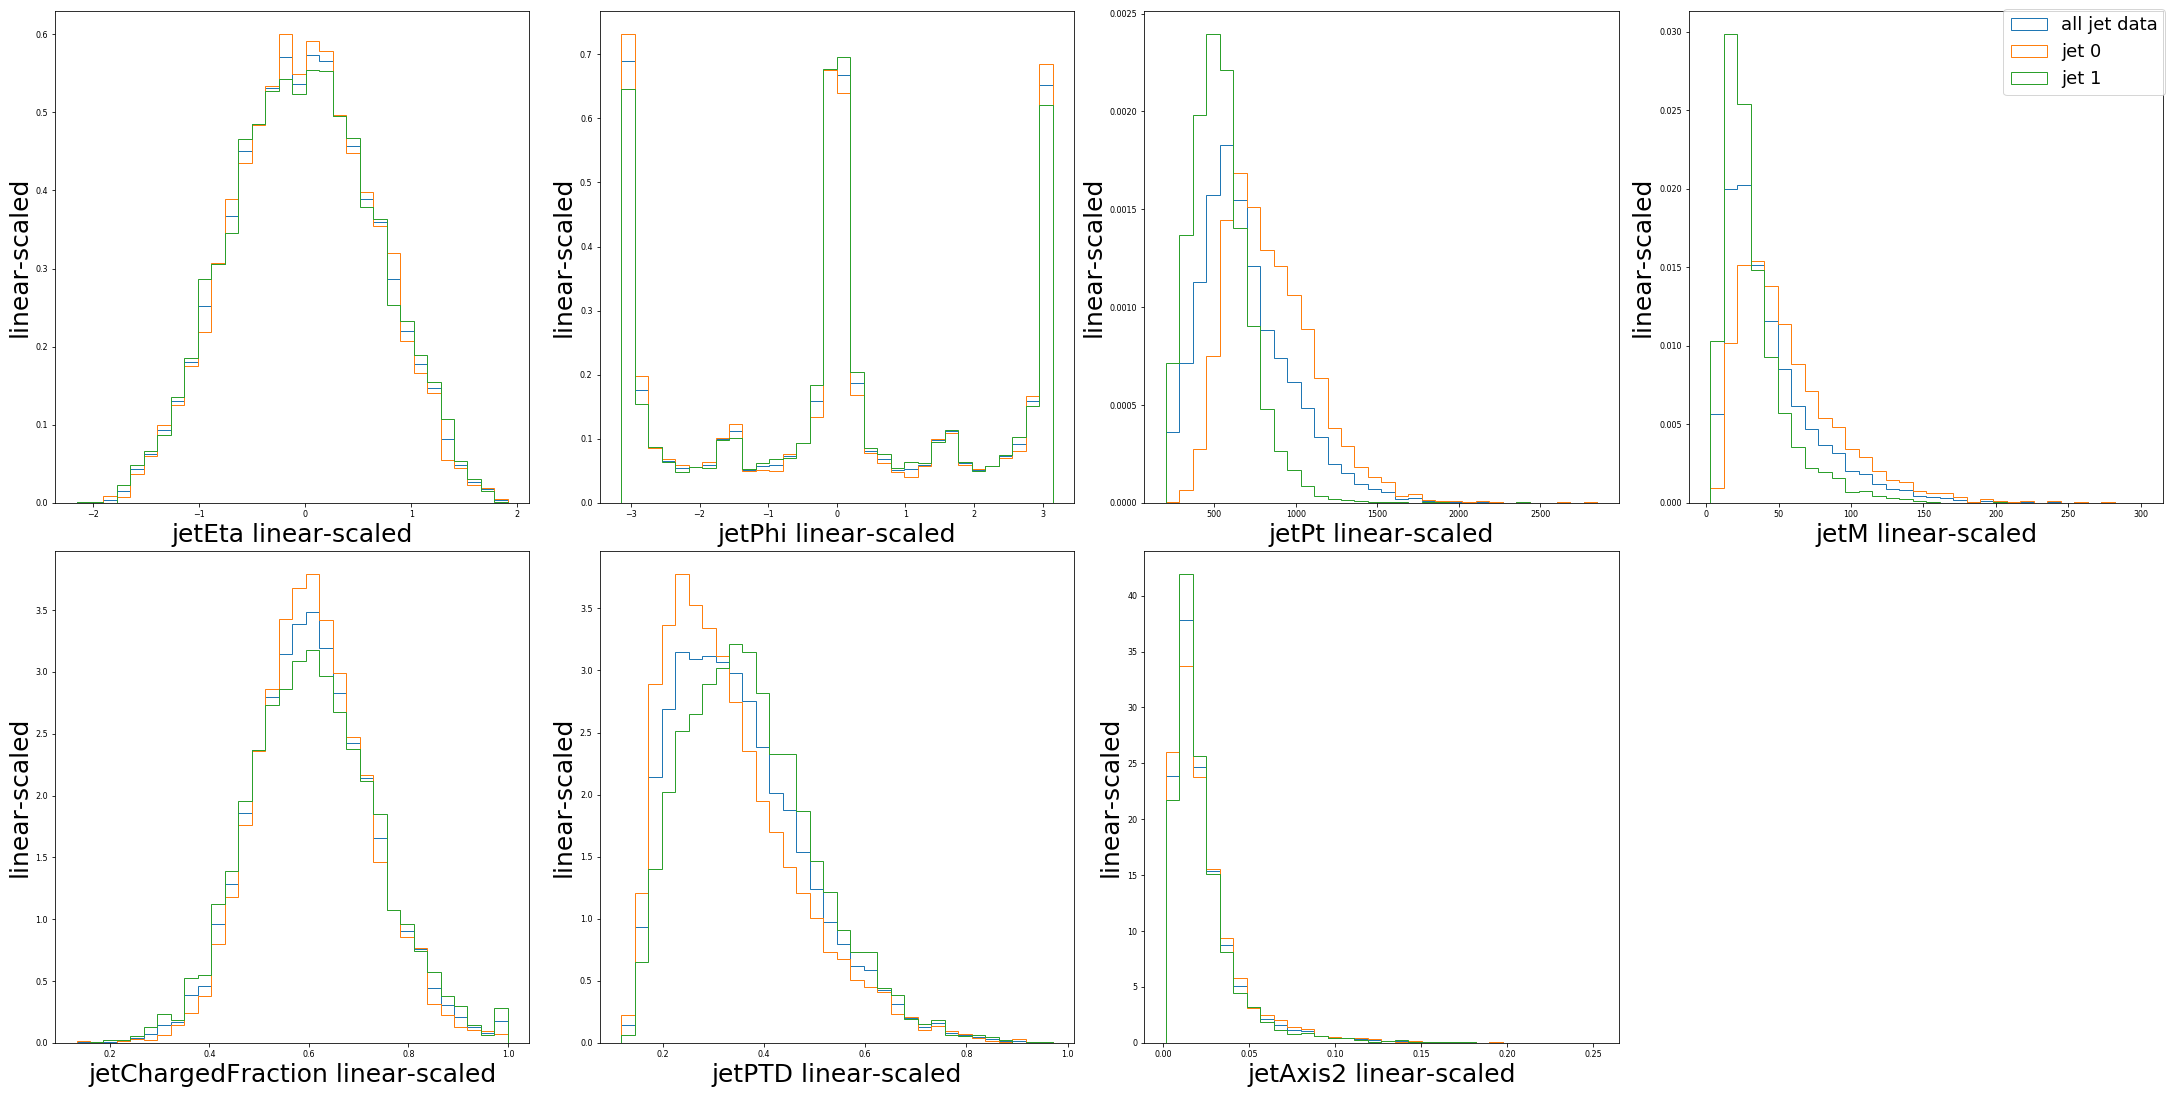

In [25]:
train, test = data.train_test_split(0.3)
data.plot([train, test], normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)
data.plot(jet_tables, normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)

We then get training/testing datasets, and normalize them to the main data set. We can check how the normalized features look compared with one another, to make sure that they are useful. This way we can decide what type of normalization to use.

data_table :: plotting distrubution(s) for table(s) ['jetEta', 'jetPhi', 'jetPt', 'jetM', 'jetChargedFraction', 'jetPTD', 'jetAxis2']


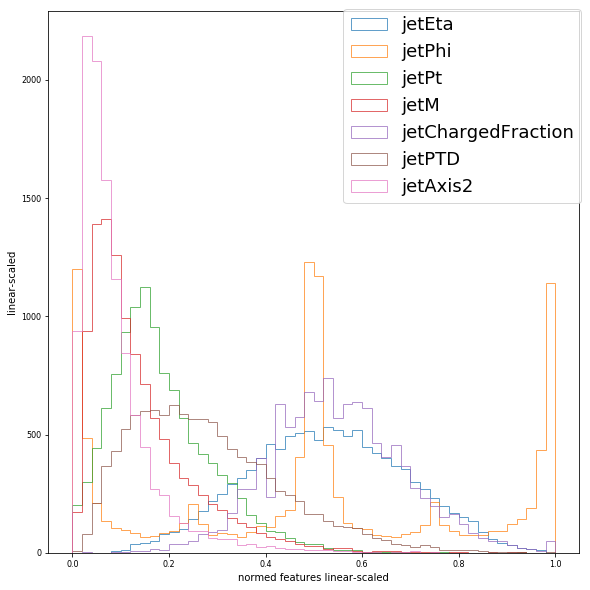

data_table :: plotting distrubution(s) for table(s) ['jetEta', 'jetPhi', 'jetPt', 'jetM', 'jetChargedFraction', 'jetPTD', 'jetAxis2']


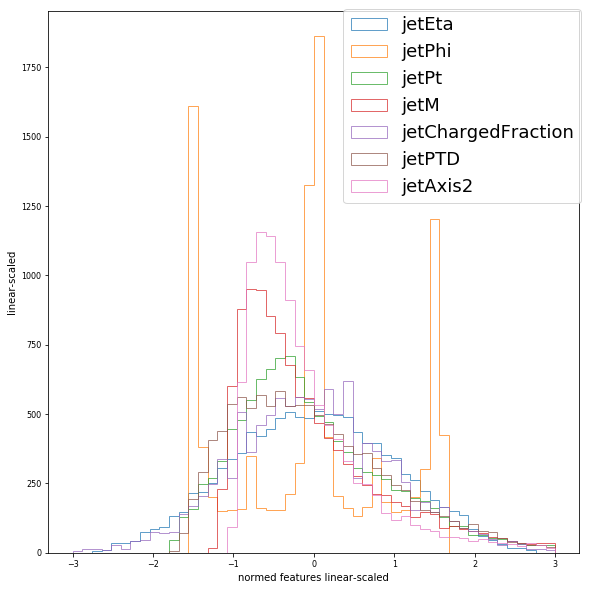

data_table :: plotting distrubution(s) for table(s) ['jetEta', 'jetPhi', 'jetPt', 'jetM', 'jetChargedFraction', 'jetPTD', 'jetAxis2']


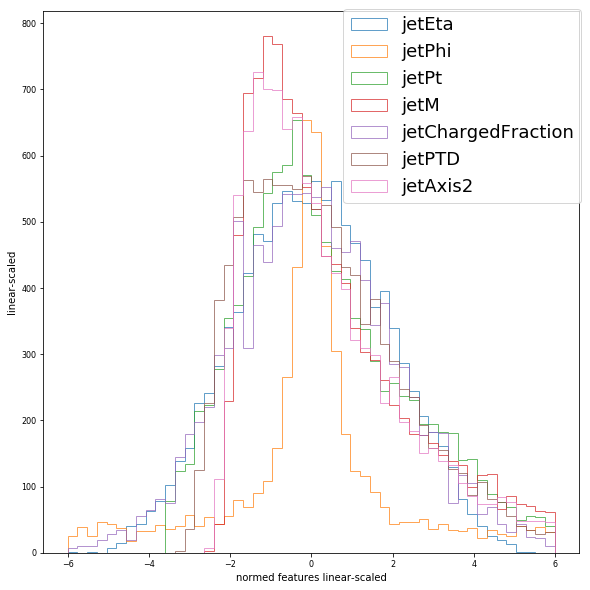

In [26]:
ntype="MinMaxScaler"
norm_data = data.norm(norm_type=ntype)
features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
features[0].plot(features[1:], bins=50, rng=(0,1), figsize=(8,8), fontsize=10)

ntype="StandardScaler"
norm_data = data.norm(norm_type=ntype)
features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
features[0].plot(features[1:], bins=50, rng=(-3,3), figsize=(8,8), fontsize=10)

norm_type="RobustScaler"
q_min = 40
quantile_range=(q_min,100-q_min)
norm_args = {
    "norm_type": norm_type,
    "quantile_range": quantile_range
}
norm_data = data.norm(**norm_args)
features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10, rng=(-6,6))

# rmin, rmax = np.asarray([(data.median() - 2.*data.std()).values, (data.median() + 2.*data.std()).values])
# custom_norm = lambda x: (x - rmin) / (rmax - rmin)
# # norm_data = data.norm(norm_type=0, rng=rng)
# norm_data = custom_norm(data)
# features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
# features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

we will use `RobustScaler`, because the results look the best (and train the best ;-))

In [27]:
train_norm, test_norm = data.norm(train, **norm_args), data.norm(test, **norm_args)
# print train_norm.shape, test_norm.shape
# train_norm, test_norm = (
#     utils.data_table(custom_norm(train), name="norm train", headers=train.headers),
#     utils.data_table(custom_norm(test), name="norm test", headers=test.headers),
# )

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [34]:
ae_skeleton = models.base_autoencoder()
ae_skeleton.add(7)
ae_skeleton.add(30)
ae_skeleton.add(5, 'relu')
ae_skeleton.add(30)
ae_skeleton.add(7, "linear")
autoencoder = ae_skeleton.build()
encoder, decoder = autoencoder.layers[1:]
name = "deep_5_good_test"
instance = trainer.trainer(os.path.join("../data/training_runs/7jf/", name))

h5_elt 'metric_names' :: creating group 'data' in file 'deep_5_good_test.h5'
h5_elt 'metric_names' :: creating dataset 'data/metric_names' in file 'deep_5_good_test.h5'
h5_elt 'training' :: creating group 'params' in file 'deep_5_good_test.h5'
h5_elt 'training' :: creating dataset 'params/training' in file 'deep_5_good_test.h5'
h5_elt 'config' :: creating dataset 'params/config' in file 'deep_5_good_test.h5'


... and the model summaries:

In [35]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()


encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
layer_2 (Dense)              (None, 30)                240       
_________________________________________________________________
layer_3 (Dense)              (None, 5)                 155       
Total params: 395
Trainable params: 395
Non-trainable params: 0
_________________________________________________________________


decoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
layer_4 (Dense)              (None, 30)                180       
__________________________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [36]:
# name = "medium_4_test"
# instance = trainer.trainer(os.path.join("../data/training_runs/7jf/mean_std_norm/", name))

training is easy:

In [38]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

autoencoder = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss="mse",
    epochs=40,
    model=autoencoder,
    metrics=[r_square, "mae", "mse"],
    force=False,
    batch_size=128,
    use_callbacks=False,
    learning_rate=0.001
)

train_shell :: ERROR: IGNORING PASSED PARAMETER 'model'
train_shell :: using saved model
train_shell :: TRAINING EPOCH 40/80
Train on 7865 samples, validate on 3371 samples
Epoch 41/41
61/61 [==============================] - 1s 19ms/step - loss: 0.2358 - r_square: 0.9852 - mean_absolute_error: 0.3192 - mean_squared_error: 0.2358 - val_loss: 0.2253 - val_r_square: 0.9862 - val_mean_absolute_error: 0.3099 - val_mean_squared_error: 0.2253
train_shell :: TRAINING EPOCH 41/80
Train on 7865 samples, validate on 3371 samples
Epoch 42/42
61/61 [==============================] - 1s 13ms/step - loss: 0.2290 - r_square: 0.9857 - mean_absolute_error: 0.3081 - mean_squared_error: 0.2290 - val_loss: 0.2240 - val_r_square: 0.9863 - val_mean_absolute_error: 0.3080 - val_mean_squared_error: 0.2240
train_shell :: TRAINING EPOCH 42/80
Train on 7865 samples, validate on 3371 samples
Epoch 43/43
61/61 [==============================] - 1s 14ms/step - loss: 0.2274 - r_square: 0.9858 - mean_absolute_error: 

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

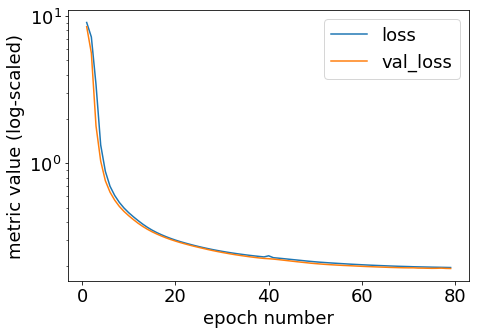

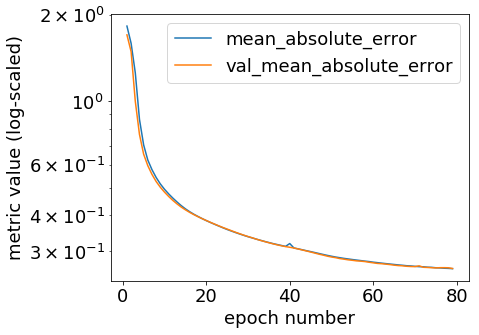

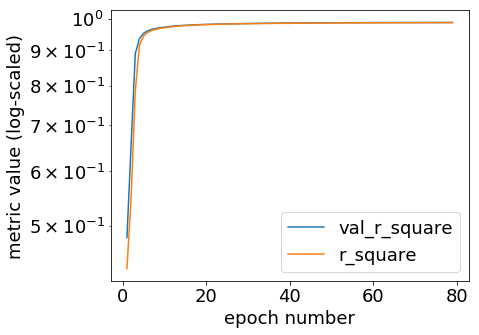

In [48]:
instance.plot_metrics(fnmatch_criteria="*loss*", yscale="log")
instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="log")
instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="log")

checking results:

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'all jet data (pred)']


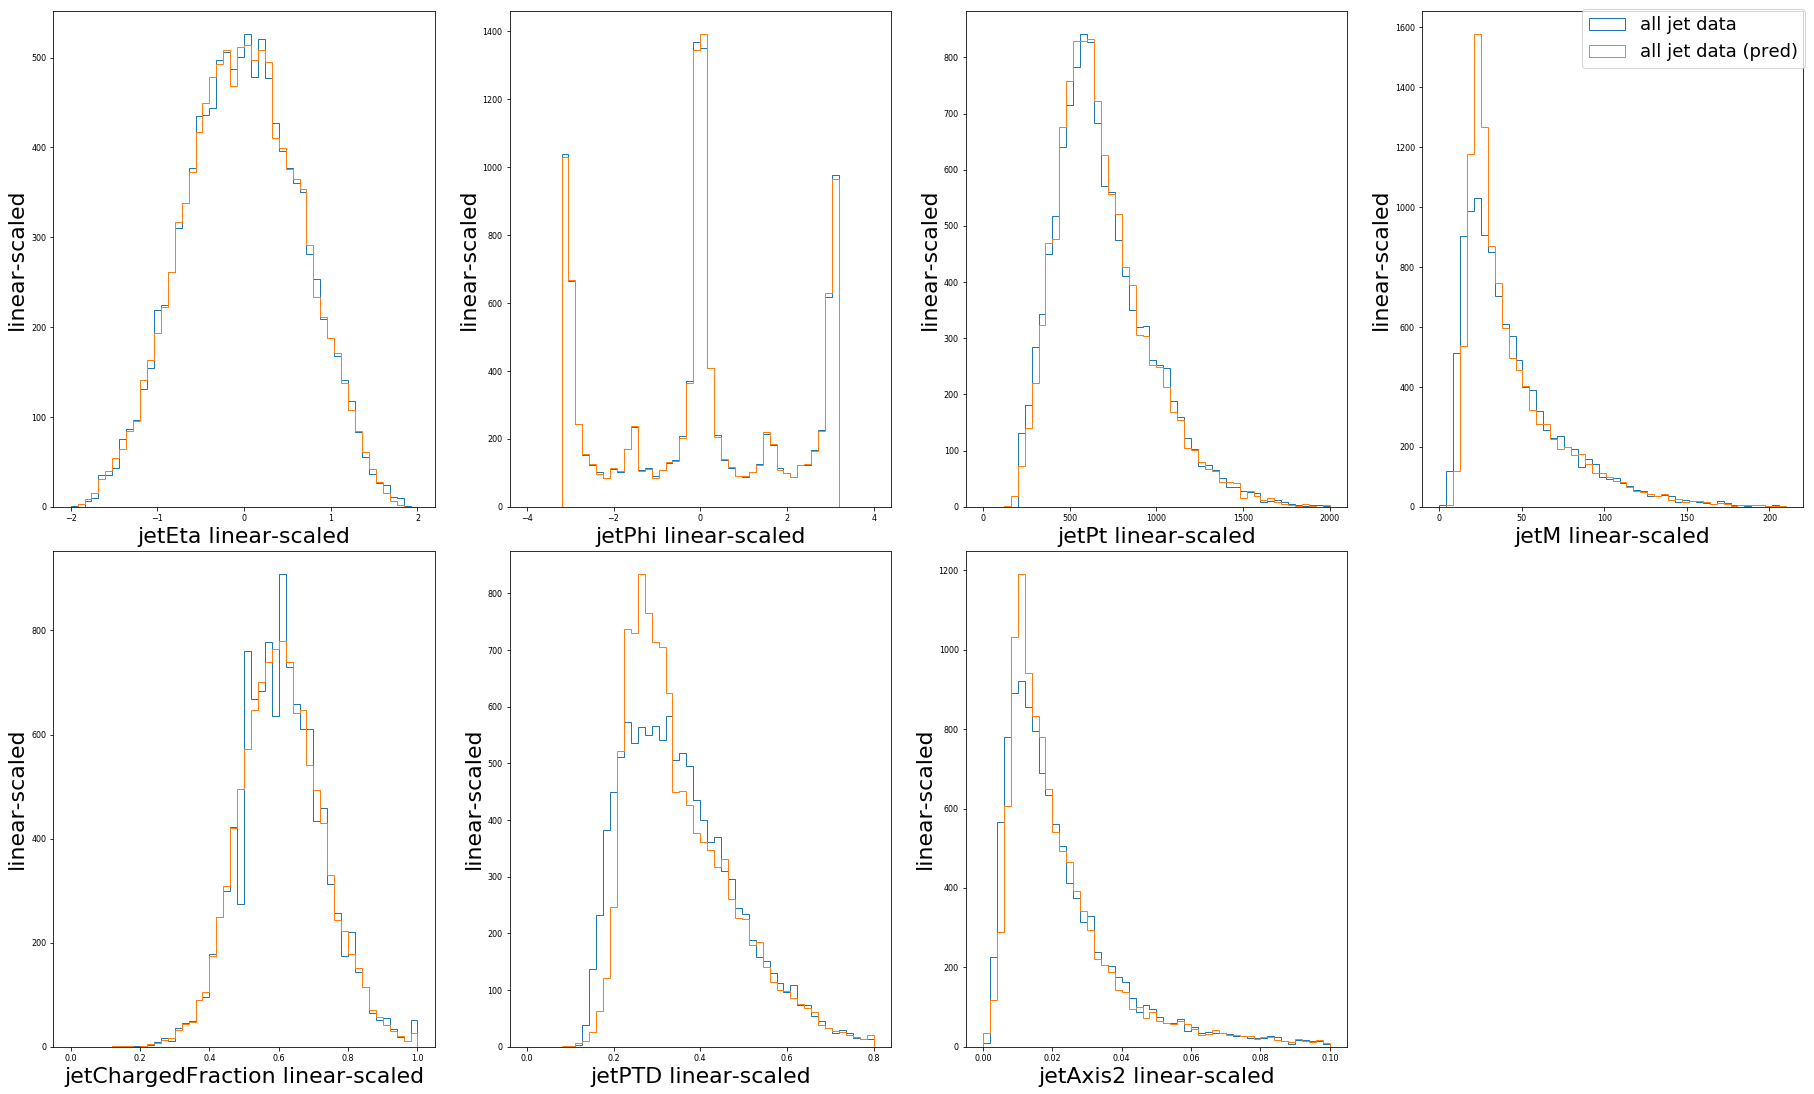

data_table :: plotting distrubution(s) for table(s) ["'all jet data' normed to 'all jet data'", 'untitled 130']


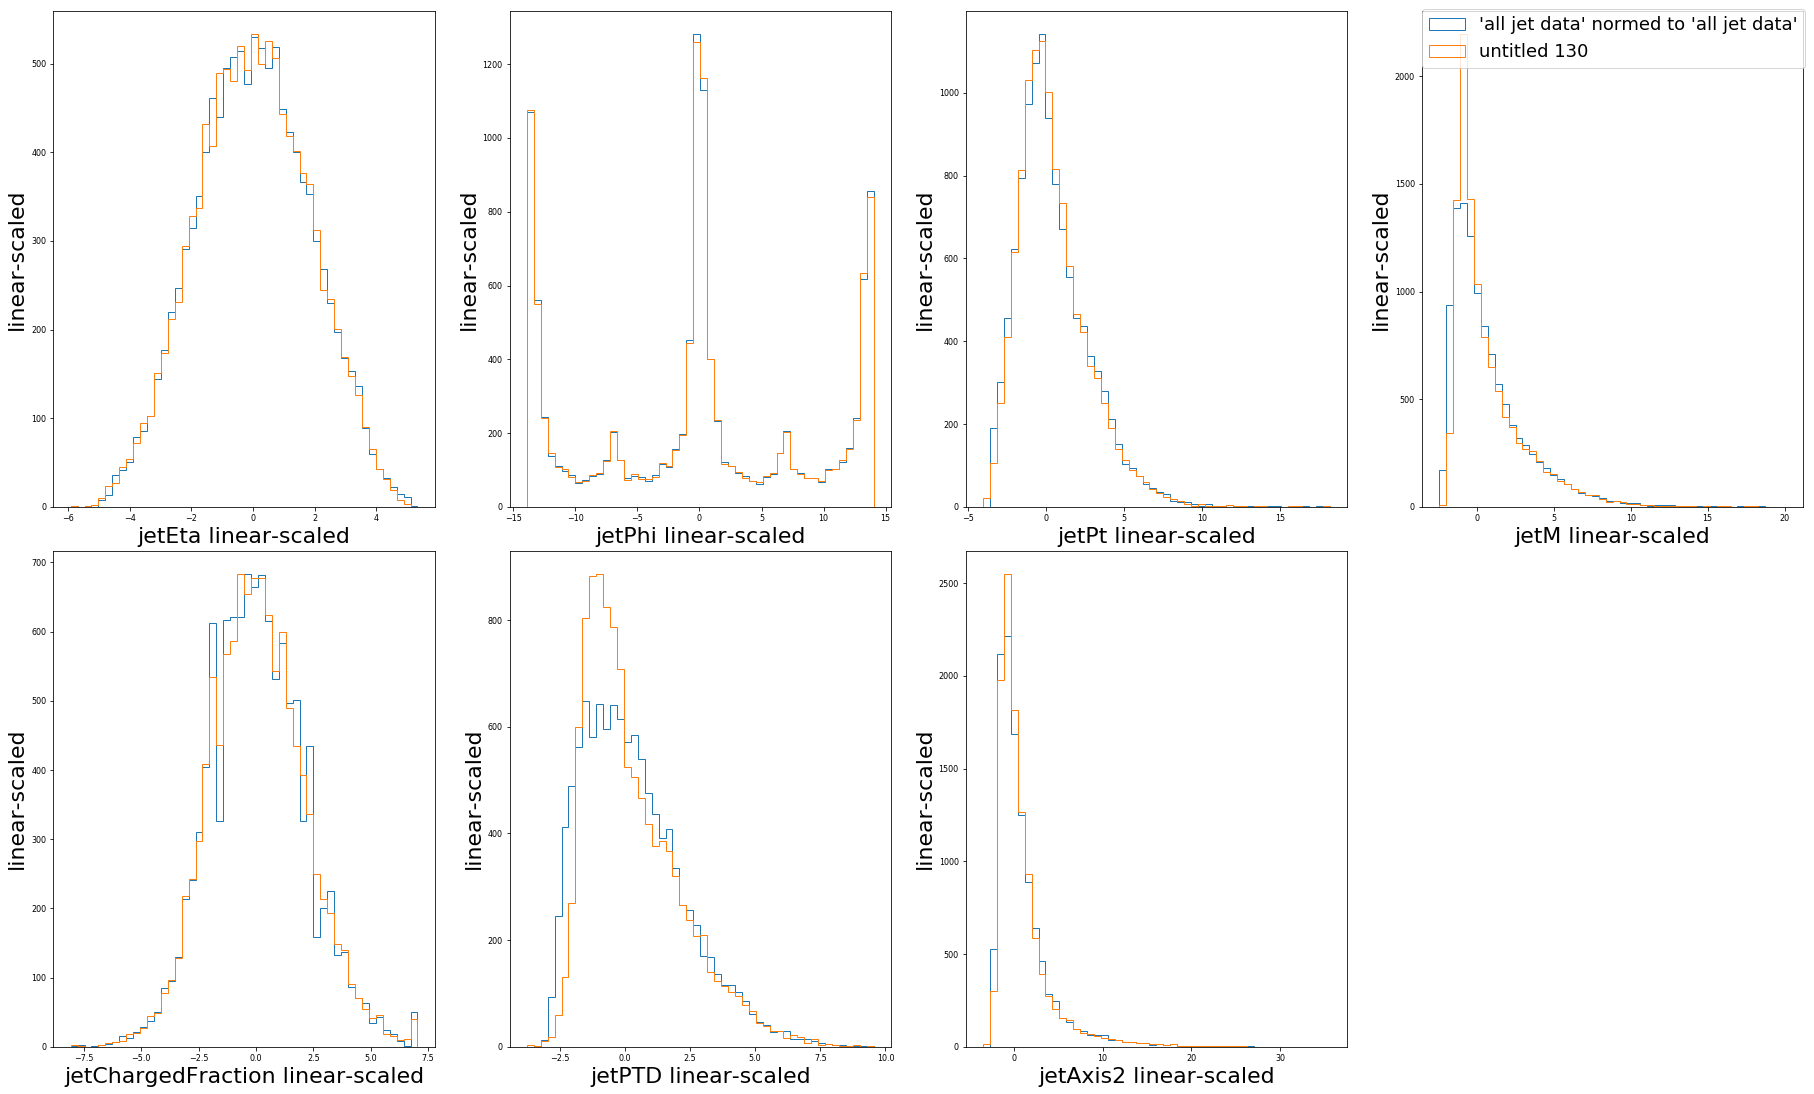

In [49]:

data_recon_norm = utils.data_table(autoencoder.predict(data.norm(**norm_args).df.values), headers=train_norm.headers)
data_recon = data.inorm(data_recon_norm, **norm_args)
data_recon.name = "all jet data (pred)"

# train_reconstructed_norm = data_table(autoencoder.predict(train_norm.data), headers=train_norm.headers)
# test_reconstructed_norm = data_table(autoencoder.predict(test_norm.data), headers=test_norm.headers)

# train_reconstructed = data.inorm(train_reconstructed_norm)
# # test_reconstructed = data.inorm(test_reconstructed_norm)


# train_reconstructed.name = "train reconstructed"
# test_reconstructed.name = "test reconstructed"

# train.plot([train_reconstructed], bins = 30, alpha=1.0)
# test.plot([test_reconstructed], bins=30, alpha=1.0)
data.plot(
#     [train_reconstructed, test_reconstructed],
    data_recon,
    normed=0, bins=50, alpha=1.0, figloc="upper right",
    figsize=(25,15), fontsize=22, rng=[(-2,2), (-4,4), (0,2000), (0,210), (0,1), (0,0.8), (0, .10)]
)

data.norm(**norm_args).plot(
    data_recon_norm,
    normed=0, bins=50, alpha=1.0, figloc="upper right",
    figsize=(25,15), fontsize=22
)

In [50]:
encoder, decoder = autoencoder.layers[1:]
train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), name="test_reps")
)

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


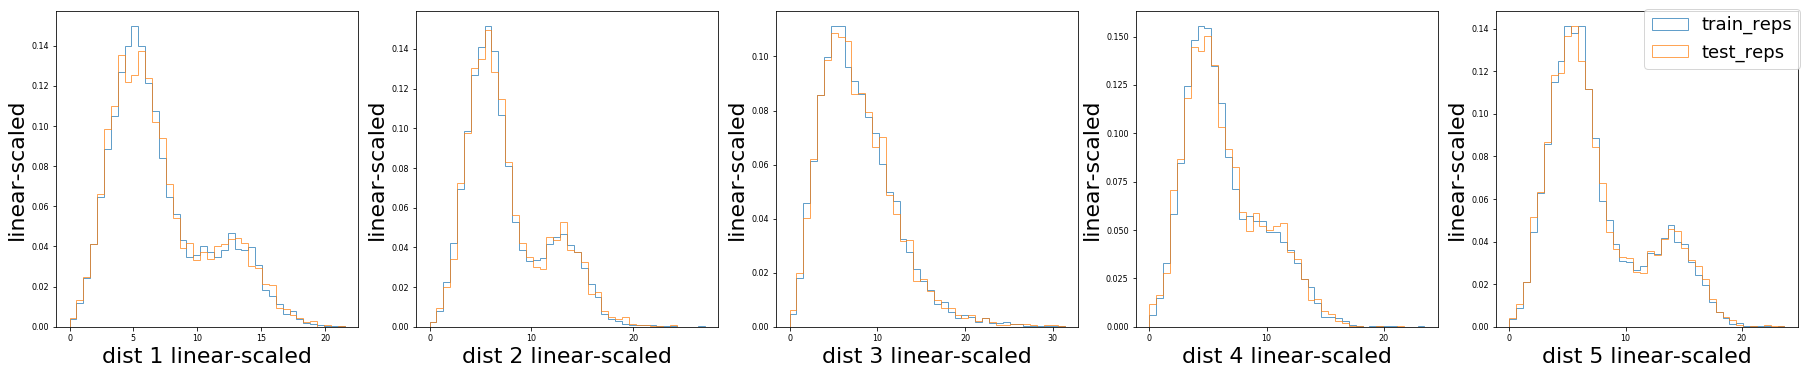

In [51]:
train_reps.plot([test_reps], cols=5, figsize=(25,5), fontsize=22, normed=1, bins=40)
